# ANBW_v2
- Bigger resolution
- Dacon baseline model -> EfficientNetB3
- threshold(for preprocessing) not specified

## Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"

In [2]:
import gc
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [3]:
print("CUDA avilable:",
     True if tf.config.list_physical_devices("GPU") else False)

CUDA avilable: True


In [30]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [4]:
# 재현성 및 동일 조건을 만들기 위해 seed 설정
np.random.seed(1234)
tf.random.set_seed(1234)

## Load data

In [5]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/submission.csv")

## EDA

### Train data

In [6]:
train.set_index("id").head()

,digit,letter,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
id,,,,,,,,,,,,,,,,,,,,,
1,5,L,1,1,1,4,3,0,0,4,...,2,1,0,1,2,4,4,4,3,4
2,0,B,0,4,0,0,4,1,1,1,...,0,3,0,1,4,1,4,2,1,2
3,4,L,1,1,2,2,1,1,1,0,...,3,3,3,0,2,0,3,0,2,2
4,9,D,1,2,0,2,0,4,0,3,...,3,3,2,0,1,4,0,0,1,1
5,6,A,3,0,2,4,0,3,0,4,...,4,4,3,2,1,3,4,3,1,2


In [7]:
train.shape

(2048, 787)

### Test data

In [8]:
test.set_index("id").head()

,letter,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
id,,,,,,,,,,,,,,,,,,,,,
2049,L,0,4,0,2,4,2,3,1,0,...,2,0,4,2,2,4,3,4,1,4
2050,C,4,1,4,0,1,1,0,2,2,...,0,3,2,4,2,4,2,2,1,2
2051,S,0,4,0,1,3,2,3,0,2,...,1,3,2,0,3,2,3,0,1,4
2052,K,2,1,3,3,3,4,3,0,0,...,3,0,3,2,4,1,0,4,4,4
2053,W,1,0,1,1,2,2,1,4,1,...,4,3,1,4,0,2,1,2,3,4


In [9]:
test.shape

(20480, 786)

### Visualize data

In [10]:
# 시각화할 train 데이터 9개를 무작위로 추출
random_data = train.sample(frac=1).reset_index(drop=True).loc[:8]
random_data

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,321,2,Y,0,3,1,3,3,0,4,...,1,2,0,2,2,3,4,1,1,4
1,1449,4,B,3,1,2,3,3,0,1,...,0,3,3,4,3,2,0,3,4,4
2,2005,6,B,2,3,1,0,2,4,4,...,0,3,2,0,0,0,1,1,4,0
3,580,8,V,1,4,3,0,2,3,3,...,2,2,2,2,0,3,1,4,4,4
4,314,7,P,4,3,3,4,2,3,0,...,0,2,1,4,2,0,3,3,0,3
5,725,6,A,4,2,1,2,2,1,3,...,2,0,3,2,1,3,1,4,4,2
6,235,1,E,0,0,0,1,1,3,4,...,2,4,2,1,1,4,4,4,2,3
7,1418,4,F,4,0,3,4,4,2,2,...,2,4,1,2,2,0,4,0,2,1
8,22,0,Y,4,2,4,0,0,1,4,...,4,0,4,4,3,4,2,3,2,0


In [11]:
# 시각화할 데이터의 정보 추출
random_imgs = []
for random_img in list(random_data.loc[:8., "0": ].values):
    random_imgs.append(random_img.reshape(28, 28).astype(int))

digits = list(random_data.loc[:8, "digit"].values)
letters = list(random_data.loc[:8, "letter"].values)

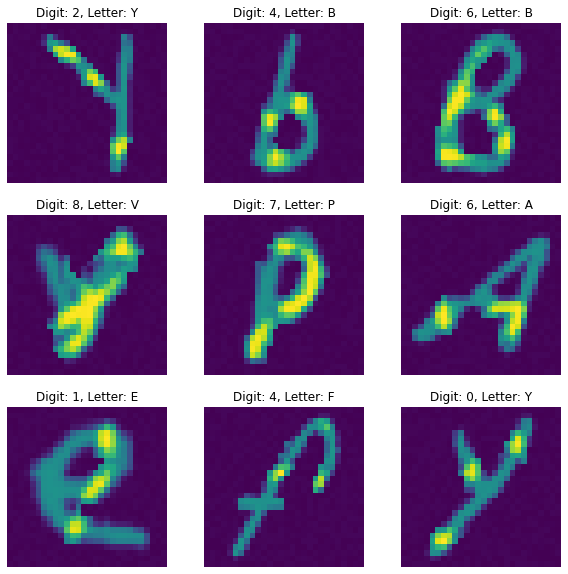

In [12]:
# 데이터 시각화 (original)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(random_imgs[i])
    plt.title("Digit: %s, Letter: %s" % (digits[i], letters[i]))
    plt.axis("off")

# 시각화 사진 저장
img_save_path = "./img/v2/"

if not(os.path.isdir(img_save_path)):
    os.makedirs(os.path.join(img_save_path))
    
img_name = img_save_path + "random_train_visualize.png"
if not(os.path.isfile(img_name)):
    plt.savefig(img_save_path + "random_train_visualize.png", facecolor="#eeeeee", bbox_inches="tight")

## Data preprocessing

In [13]:
x_train = train.drop(["id", "digit", "letter"], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1)

# threshold 미지정
# x_train = np.where((x_train<=20)&(x_train!=0) ,0.,x_train)
x_train = x_train/255
x_train = x_train.astype("float32")
x_train.shape

(2048, 28, 28, 1)

In [14]:
y = train["digit"]
y_train = np.zeros((len(y), len(y.unique())))

for idx, digit in enumerate(y):
    y_train[idx, digit] = 1

y_train.shape

(2048, 10)

In [15]:
x_train_resized = np.zeros([2048, 280, 280, 3], dtype=np.float32)
x_train_resized.shape

(2048, 280, 280, 3)

In [16]:
# (28, 28, 1) -> (280, 280, 1) resize
for idx, img in enumerate(x_train):
    converted = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    resized = cv2.resize(converted, (280, 280), interpolation=cv2.INTER_CUBIC)
    del converted
    x_train_resized[idx] = resized
    del resized
    gc.collect()

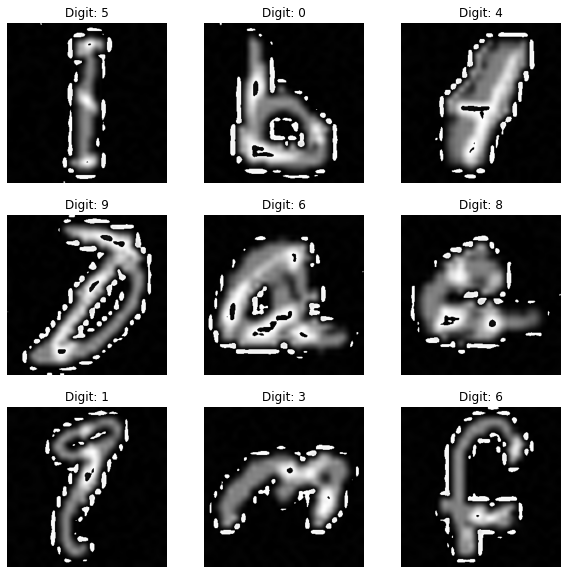

In [17]:
# 데이터 시각화
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow((x_train_resized[i] * 255).astype(np.uint8))
    plt.title("Digit: %s" % (y[i]))
    plt.axis("off")

# 시각화 사진 저장
img_save_path = "./img/v2/"

if not(os.path.isdir(img_save_path)):
    os.makedirs(os.path.join(img_save_path))

img_name = img_save_path + "resized_train_visualize.png"
if not(os.path.isfile(img_name)):
    plt.savefig(img_name, facecolor="#eeeeee", bbox_inches="tight")

In [18]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_resized, y_train, test_size=0.2, shuffle=True)

In [19]:
del x_train_resized
del random_imgs
gc.collect()

17584

## Initialing model

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [21]:
EPOCHS = 200

patient = 2
CALLBACKS = [
    EarlyStopping(
    monitor="val_loss",
    patience=patient,
    mode="min",
    verbose=1
    ),
    ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=patient/2,
    min_lr=0.00001,
    verbose=1,
    mode="min"
    )
]

In [22]:
effnet = tf.keras.applications.EfficientNetB3(
    include_top=True,
    weights=None,
    input_shape=(280, 280, 3),
    classes=10,
    classifier_activation="softmax",
)

In [23]:
model = tf.keras.Sequential()
model.add(effnet)

model.compile(loss="categorical_crossentropy",
             optimizer="RMSprop",
             metrics=["accuracy"])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 10)                10798905  
Total params: 10,798,905
Trainable params: 10,711,602
Non-trainable params: 87,303
_________________________________________________________________


## Train the Model

In [26]:
history = model.fit(x_train, y_train, batch_size=16, epochs=EPOCHS, validation_data=(x_valid, y_valid))

Epoch 1/200


ResourceExhaustedError:  OOM when allocating tensor with shape[16,288,35,35] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential/efficientnetb3/block4a_expand_activation/Sigmoid (defined at <ipython-input-25-8c8461bb2331>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_39745]

Function call stack:
train_function
